##### Estadisticas generales sobre el covid-19

In [1]:
import numpy as np

from utilidades import *

# data = load_data_jhu('argentina')
data = load_data()
x = range(len(data[0]))

##### Casos

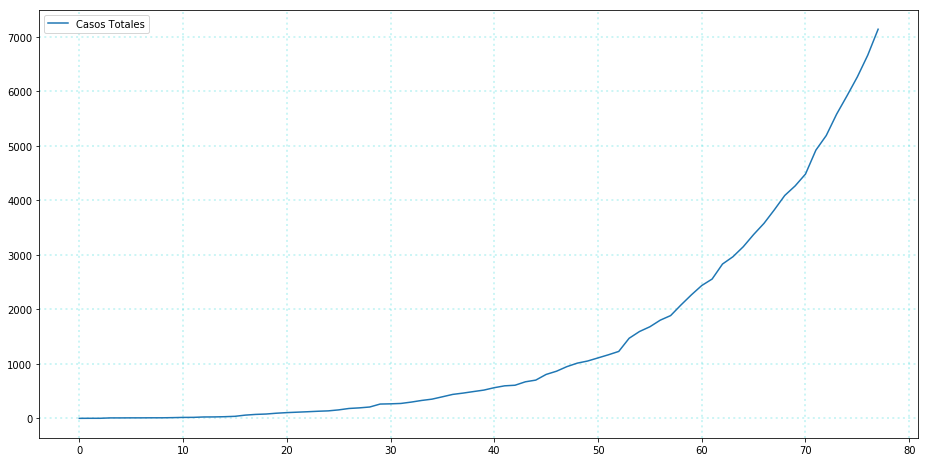

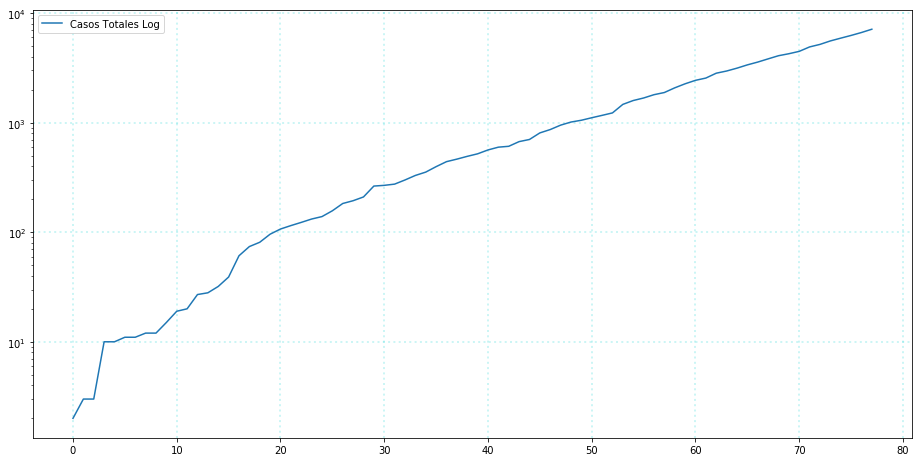

In [2]:
ax = plot(x, data[1], labels=['Casos Totales'])
ax = plot(x, data[1], labels=['Casos Totales Log'])
ax.set_yscale('log')


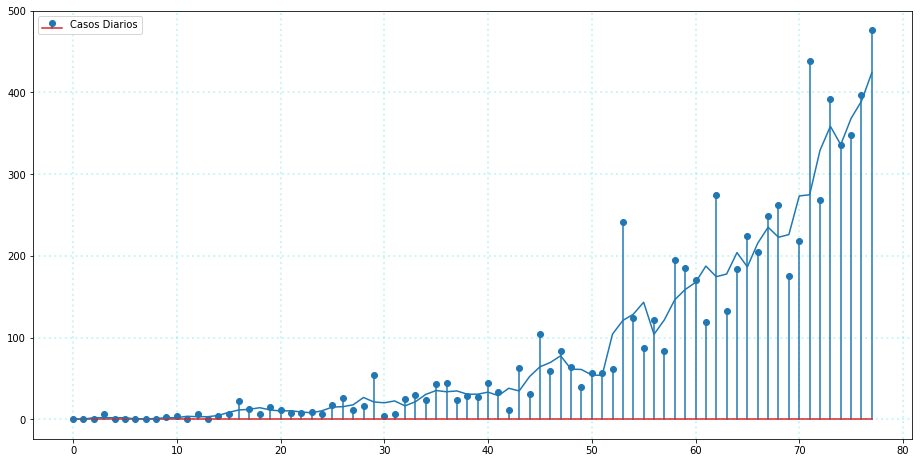

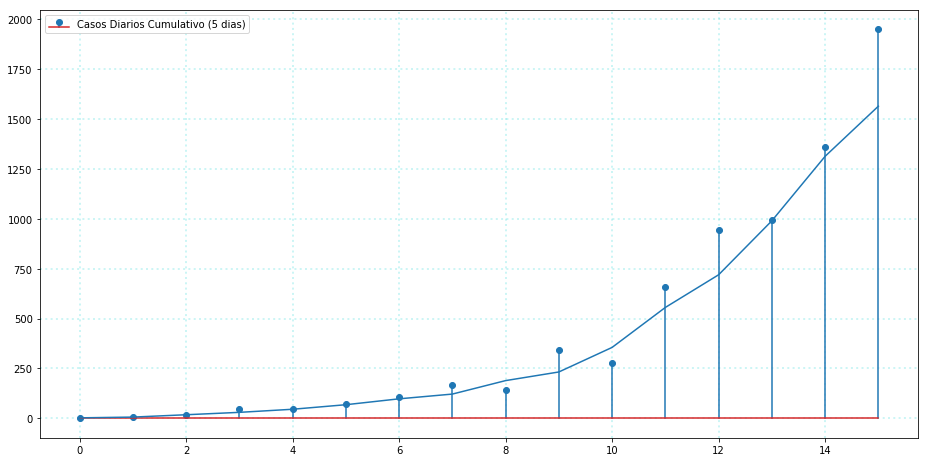

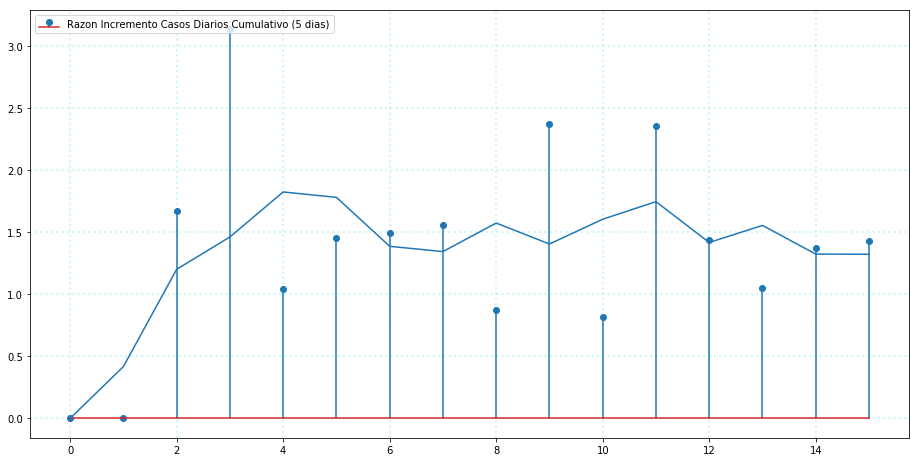

In [3]:
new_cases = np.diff(data[1], prepend=[data[1][0]])
plot_moving_averaged(new_cases, label='Casos Diarios')

pad_cases = np.pad(new_cases, (5 - len(new_cases) % 5, 0), 'constant', constant_values=(0,))
cum_cases = [sum(pad_cases[_ * 5:(_ + 1) * 5]) for _ in range(int(len(pad_cases) / 5))]
plot_moving_averaged(cum_cases, label='Casos Diarios Cumulativo (5 dias)')

# Si menor a 1, los casos se estan reduciendo (perfecto)
# Si entre 1 y 2, los casos se estan duplicado en mas de 5 dias (mas o menos, depende cuan cerca este al 1)
# Si igual a 2, los casos se estan duplicando cada 5 dias (preocupante)
# Si mayor a 2, los casos se estan duplicando en menos de 5 dias (muy preocupante)
cum_cases = np.array(cum_cases)
cum_cases[cum_cases < 1.] = 1.
inc_cases = [0] * 2 + [cum_cases[_ + 1] / cum_cases[_] for _ in range(1, len(cum_cases) - 1)]
inc_cases = np.array(inc_cases)
inc_cases[inc_cases > 10.] = 10.
plot_moving_averaged(inc_cases, label='Razon Incremento Casos Diarios Cumulativo (5 dias)')


###### R_t 

avg (30d): 1.5617722554428046
lat: 1.5472783731125181 +- 0.15039481338691774


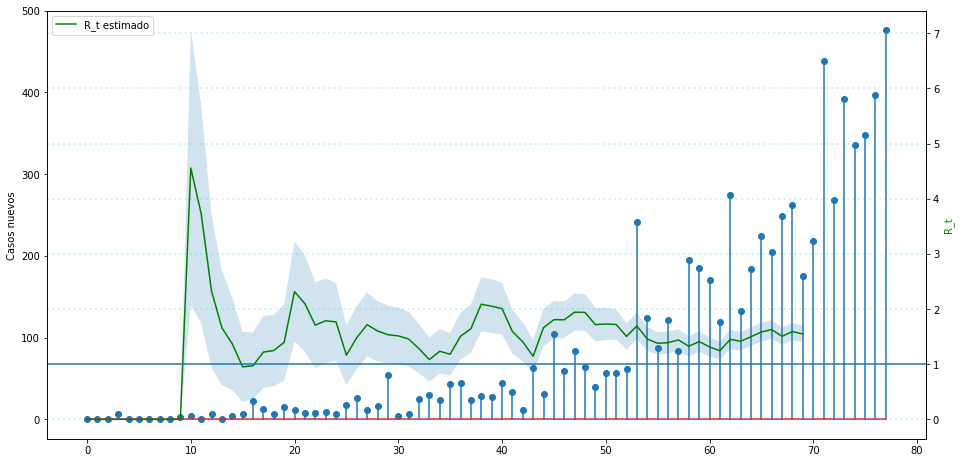

In [4]:
r_ts, r_ts_min, r_ts_max = estimate_rt(new_cases, window_size=5)

fig, ax = pyplot.subplots()
ax.stem(new_cases)
ax.set_ylabel('Casos nuevos')

ax2 = ax.twinx()
ax2.set_ylabel('R_t', color='green')
ax2.plot(r_ts, color='green', label='R_t estimado')
ax2.fill_between(
    range(len(r_ts)),
    r_ts_min,
    r_ts_max,
    alpha=0.2
)
ax2.legend(loc='upper left')

ax2.axhline(1.)
pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)

print('avg (30d): {}\nlat: {} +- {}'.format(np.mean(r_ts[r_ts > 0][-30:]), r_ts[-1], r_ts_max[-1] - r_ts[-1]))

Ref: https://stochastik-tu-ilmenau.github.io/COVID-19/reports/repronum/repronum.pdf

##### Fallecidos

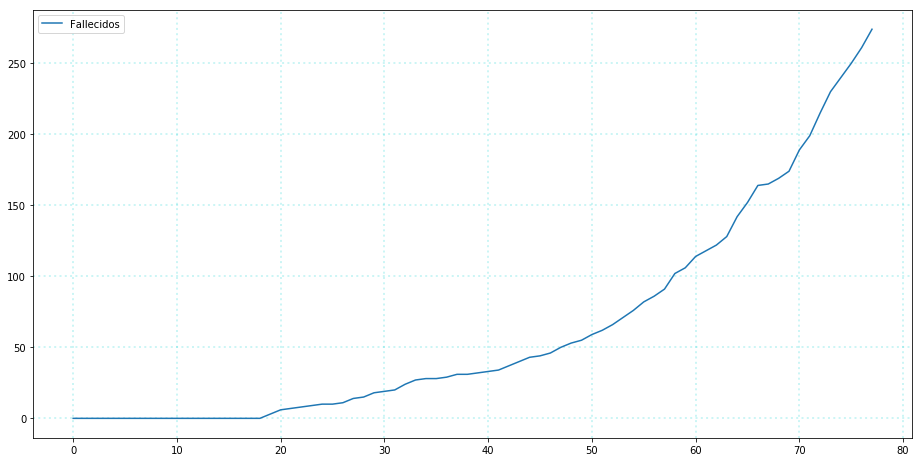

In [5]:
_ = plot(x, data[2], labels=['Fallecidos'])

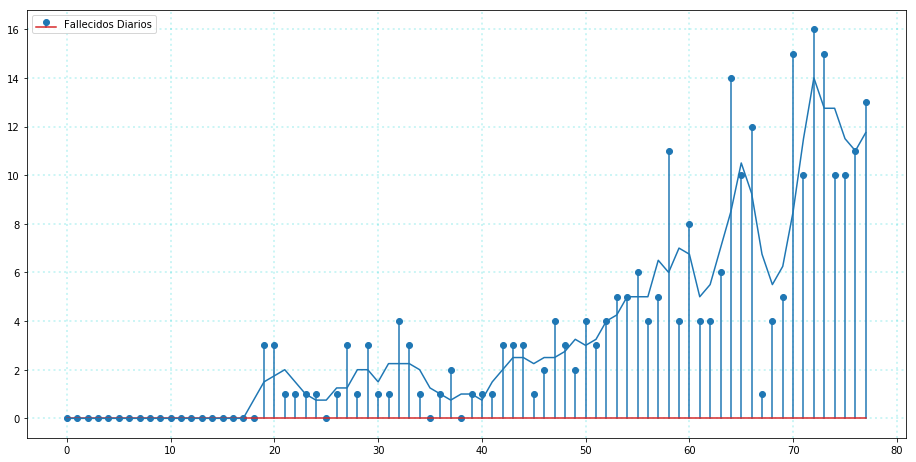

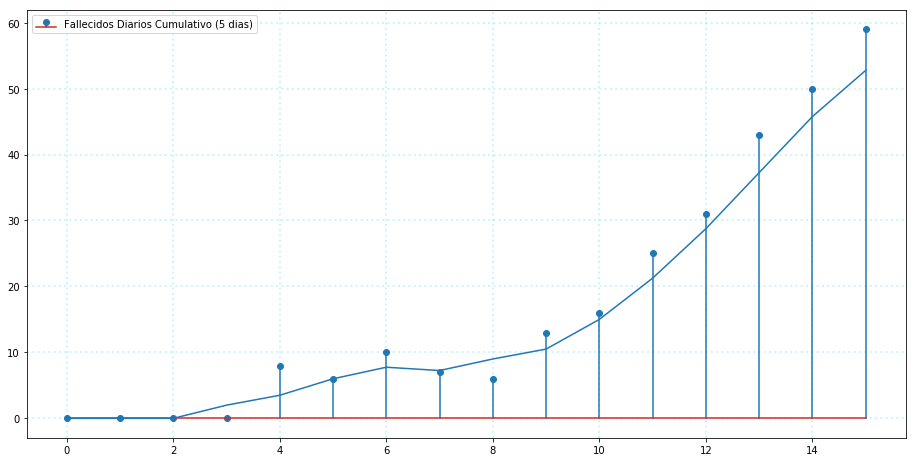

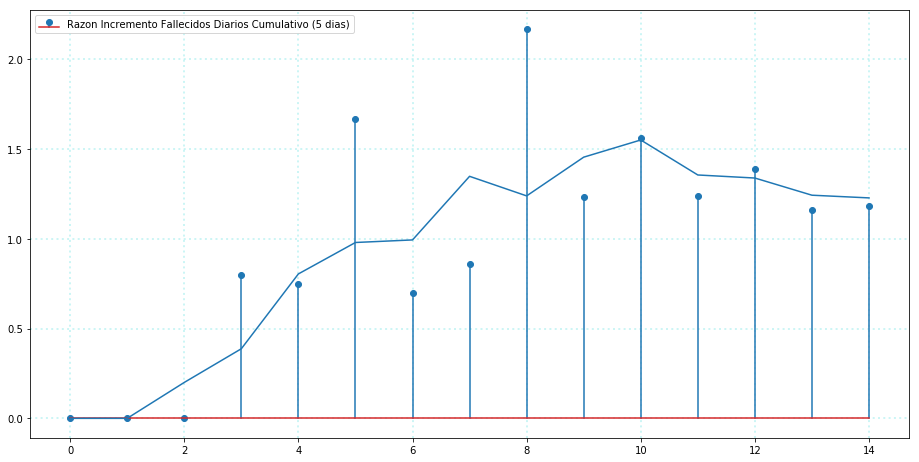

In [6]:
new_deaths = np.diff(data[2], prepend=[data[2][0]])
plot_moving_averaged(new_deaths, label='Fallecidos Diarios')

pad_deaths = np.pad(new_deaths, (5 - len(new_deaths) % 5, 0), 'constant', constant_values=(0,))
cum_deaths = [sum(pad_deaths[_ * 5:(_ + 1) * 5]) for _ in range(int(len(pad_deaths) / 5))]
plot_moving_averaged(cum_deaths, label='Fallecidos Diarios Cumulativo (5 dias)')

# Si menor a 1, los casos se estan reduciendo (perfecto)
# Si entre 1 y 2, los casos se estan duplicado en mas de 5 dias (mas o menos, depende cuan cerca este al 1)
# Si igual a 2, los casos se estan duplicando cada 5 dias (preocupante)
# Si mayor a 2, los casos se estan duplicando en menos de 5 dias (muy preocupante)
inc_deaths = [cum_deaths[_ + 1] / (cum_deaths[_] or 10.) for _ in range(len(cum_deaths) - 1)]
_ = plot_moving_averaged(inc_deaths, label='Razon Incremento Fallecidos Diarios Cumulativo (5 dias)')


##### Tests

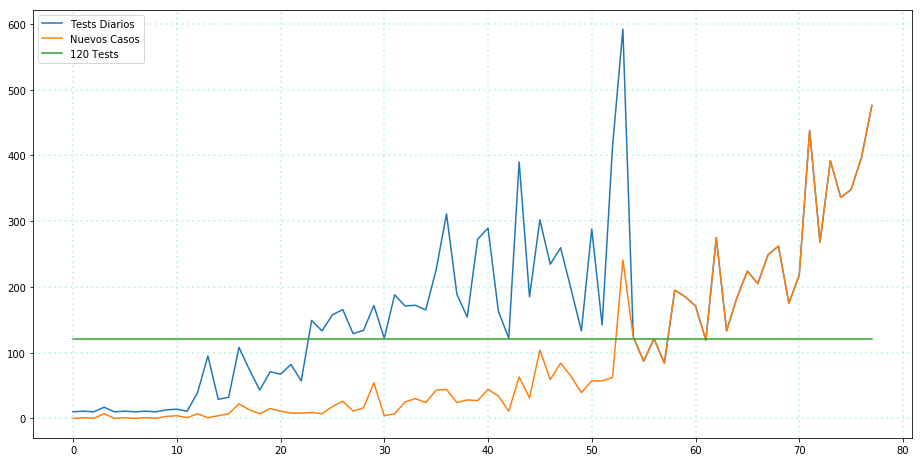

In [7]:
_ = plot(x, data[-1], new_cases, [120] * len(x), labels=['Tests Diarios', 'Nuevos Casos', '120 Tests'])

Tests Diarios = <a href='https://github.com/mauforonda/covid19-bolivia/blob/master/descartados.csv'>Descartados</a> + <a href='https://github.com/mauforonda/covid19-bolivia2/blob/master/nacional.csv'>Nuevos Casos</a>
Como referencia el 04/24, en el <a href='https://www.boliviasegura.gob.bo/comunicados_proc.php?Seleccion=23'>reporte del ministerio</a> indica que '4.490 casos fueron descartados mediante pruebas de laboratorio', misma cantidad que esta en los datos compilados por <a href='https://github.com/mauforonda'>@mauforonda</a>.  
Esto no concuerda con las declaraciones del ministro Navajas de que <a href='https://www1.abi.bo/abi_/?i=448936'>actualmente Bolivia cuenta con la capacidad de procesar en promedio de entre 115 a 120 pruebas diarias de laboratorio</a>, asi que esto queda como curiosidad mas que como dato.

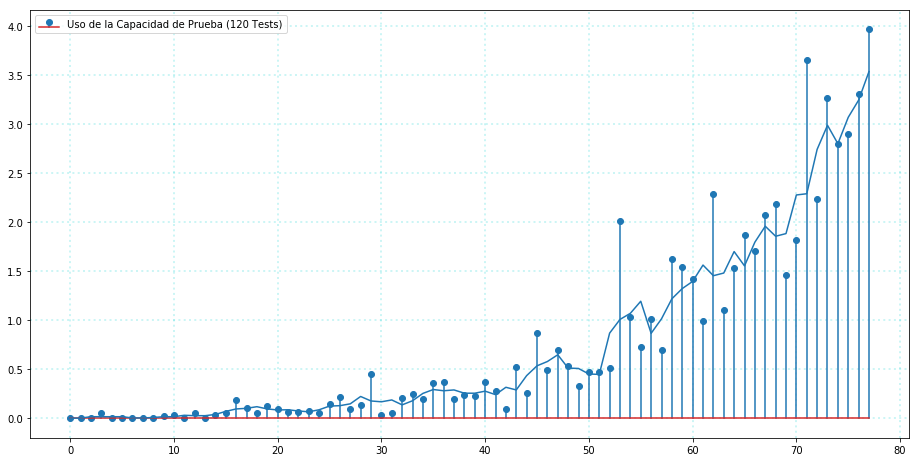

In [8]:
_ = plot_moving_averaged(
    new_cases / np.array([120] * len(x)), 
    label='Uso de la Capacidad de Prueba (120 Tests)'
)

Esto es casos detectados por dia / 120 tests por dia

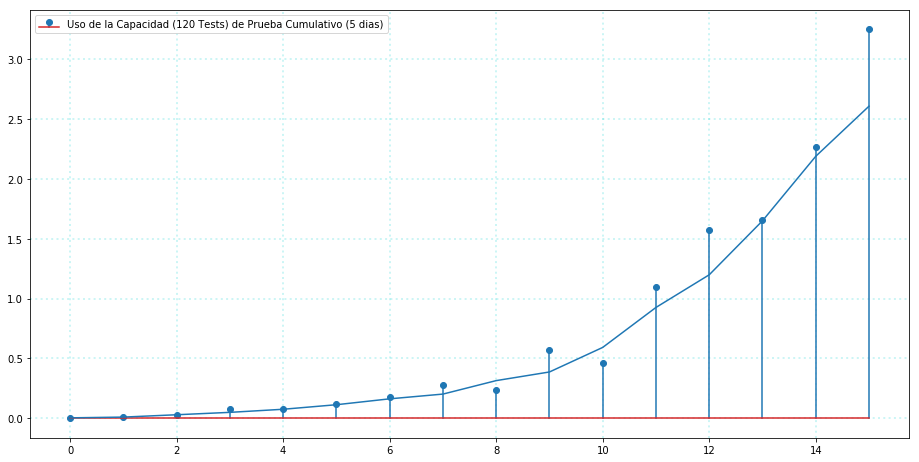

In [9]:
test_120_capacity = [_ / (120 * 5.) for _ in cum_cases]
_ = plot_moving_averaged(
    test_120_capacity, 
    label= 'Uso de la Capacidad (120 Tests) de Prueba Cumulativo (5 dias)'
)